## Salary Prediction Model for better compensation strategy

In [141]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, RobustScaler
import category_encoders as encoders
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
import xgboost as xgb
import seaborn as sns
sns.set_theme(style="whitegrid")

## Part I - Load & Clean

Here are some functions to boost the efficiency.

In [37]:
def load_file(path):
    return pd.read_csv(path)

def merge_data(df1, df2, key = None, left_index = False, right_index = False):
    '''inner join the datasets to get the matching records'''
    data = pd.merge(left = df1, right = df2, how = 'inner', on = key, left_index = left_index,
                    right_index = right_index)
    return data

def clean_data(raw_df):
    '''remove rows that contain salary <= 0 or duplicate job IDs'''
    clean_df = raw_df.drop_duplicates(subset='jobId')
    clean_df = clean_df[clean_df.salary>0]
    return clean_df


In [14]:
train_feature_file = "train_features.csv"
train_target_file = "train_salaries.csv"
test_file = "test_features.csv"

# define variables
cat_cols = ["companyId", "major", "industry"]
ord_cols = ["jobType", "degree"]
num_cols = ["yearsExperience", "milesFromMetropolis"]
target = "salary"
id_col = "jobId"


In [52]:
print("Loading data")
#Load Data
X_train = load_file(train_feature_file)
y_train = load_file(train_target_file)
X_test = load_file(test_file)

#Merge Training Data
raw_train = merge_data(X_train, y_train, key = 'jobId')

##Clean dataset and shuffle
clean_train = shuffle(clean_data(raw_train)).reset_index()

train_feature = clean_train.loc[:,clean_train.columns != target]
train_feature = train_feature.drop(['index'], axis = 1)
target_df = clean_train[target]

Loading data


## Part II - PREPROCESSING

### RobustScaler & multi-encoders preprocessor

In [ ]:
##Since the dataset has Job levels and education levels, I chose to use ordinal encoding.
def create_ordinal_mappings(ordinals: dict):
    """Given a dictionary of column name, and ordered list of levels, generates ordering for ordinal encoder."""
    result_mappings = []

    for column, ordering in ordinals.items():
        root_dict = {'col': column}
        mapping_dict = {None: 0, np.nan: 0}

        for j in range(0, len(ordering)):
            mapping_dict[ordering[j]] = j + 1

        root_dict["mapping"] = mapping_dict
        result_mappings.append(root_dict)
    return result_mappings

def create_pipeline(X_train, num_cols, ord_cols, cat_cols, ordinal_orderings):
    numeric_cols = make_pipeline(SimpleImputer(strategy = 'median'), RobustScaler())
    ordinal_mapping = create_ordinal_mappings(ordinal_orderings)
    ordinal_cols = encoders.OrdinalEncoder(mapping=ordinal_mapping)
    categorical_cols = encoders.OneHotEncoder()
    
    #numeric_cols.fit_transform(X_train)
    #ordinal_cols.fit_transform(X_train)
    #categorical_cols.fit_transform(X_train)
    
    transformers = [
                ('num', numeric_cols, num_cols),
                ('ord', ordinal_cols, ord_cols),
                ('cat', categorical_cols, cat_cols)
            ]

    col_transformer = ColumnTransformer(transformers)
    return col_transformer

In [11]:
ordinal_orderings = {
"jobType": ["JANITOR", "JUNIOR", "SENIOR", "MANAGER", "VICE_PRESIDENT", "CFO", "CTO", "CEO"],
"degree": ["NONE", "HIGH_SCHOOL", "BACHELORS", "MASTERS", "DOCTORAL"]}

In [13]:
preprocessor = create_pipeline(X_train, num_cols, ord_cols, cat_cols, ordinal_orderings)

## Part III - Training models

### Training model function

In [ ]:
def train_model(preprocessor,model, feature_df, target_df, num_procs, mean_mse, cv_std):
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    neg_mse = cross_val_score(pipeline, feature_df, target_df, cv=2, n_jobs=num_procs, scoring='neg_mean_squared_error')
    mean_mse[model] = -1.0*np.mean(neg_mse)
    cv_std[model] = np.std(neg_mse)

def print_summary(model, mean_mse, cv_std):
    print('\nModel:\n', model)
    print('Average MSE:\n', mean_mse[model])
    print('Standard deviation during CV:\n', cv_std[model])


### Define our models

In [21]:
models = []
mean_mse = {}
cv_std = {}
res = {}

#define number of processes to run in parallel
num_procs = 2

#shared model paramaters
verbose_lvl = 0

In [41]:
# OLS
lr = LinearRegression()
# PCA then OLS
lr_pca = make_pipeline(PCA(), LinearRegression())
# Random Forest
rf = RandomForestRegressor(n_estimators=80, n_jobs=num_procs, max_depth=25, min_samples_split=60, \
                           max_features=30, verbose=verbose_lvl)
# Gradient Boosting
gbm = GradientBoostingRegressor(n_estimators=300, max_depth=5, loss='ls', verbose=verbose_lvl)
# Xtreme Gradient Boosting
xgb = xgb.XGBRegressor(max_depth=3, learning_rate=0.008, n_estimators=6619, min_child_weight=9, colsample_bytree=0.56, subsample=0.56, reg_alpha=0.57, reg_lambda=4.0, tree_method="hist", random_state=1, n_jobs=2)                     


models.extend([lr, lr_pca, rf, gbm, xgb])

print("Beginning cross validation")
# Use CV to find the best model
for model in models:
    train_model(preprocessor, model, train_feature, target_df, num_procs, mean_mse, cv_std)
    print_summary(model, mean_mse, cv_std)

Beginning cross validation

Model:
 LinearRegression()
Average MSE:
 394.4409115630266
Standard deviation during CV:
 0.8089014986036034

Model:
 Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('robustscaler',
                                                                   RobustScaler())]),
                                                  ['yearsExperience',
                                                   'milesFromMetropolis']),
                                                 ('ord',
                                                  OrdinalEncoder(mapping=[{'col': 'jobType',
                                                                           'mapping': {None: 0,
            


Model:
 RandomForestRegressor(max_depth=25, max_features=30, min_samples_split=60,
                      n_estimators=150, n_jobs=2)
Average MSE:
 366.79554576519115
Standard deviation during CV:
 0.6658503663138333

Model:
 GradientBoostingRegressor(max_depth=5, n_estimators=150)
Average MSE:
 357.15753659655695
Standard deviation during CV:
 0.9260651578397017

Model:
 LinearRegression()
Average MSE:
 394.4409115630266
Standard deviation during CV:
 0.8089014986036034

Model:
 Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('robustscaler',
                                                                   RobustScaler())]),
                                                  ['yearsExperien

## Part VI - Best Model

The best model is the XGBOOST model according to the lowest MSE.

In [61]:
train_feature = preprocessor.fit_transform(train_feature)
model = min(mean_mse, key=mean_mse.get)
print('\nPredictions calculated using model with lowest MSE:')
print(model)

#train model on entire dataset
model.fit(train_feature, target_df)


Predictions calculated using model with lowest MSE:
XGBRegressor(colsample_bytree=0.56, learning_rate=0.008, min_child_weight=9,
             n_estimators=6619, n_jobs=2, random_state=1, reg_alpha=0.57,
             reg_lambda=4.0, subsample=0.56, tree_method='hist')


/Users/zhijuncai/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/zhijuncai/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[15:11:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


## Part IV - Deployment

In [42]:
X_test.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362685407687,COMP33,MANAGER,HIGH_SCHOOL,NONE,HEALTH,22,73
1,JOB1362685407688,COMP13,JUNIOR,NONE,NONE,AUTO,20,47
2,JOB1362685407689,COMP10,CTO,MASTERS,BIOLOGY,HEALTH,17,9
3,JOB1362685407690,COMP21,MANAGER,HIGH_SCHOOL,NONE,OIL,14,96
4,JOB1362685407691,COMP36,JUNIOR,DOCTORAL,BIOLOGY,OIL,10,44


In [55]:
#Use the same encoding and scaler as the training set
test_df = preprocessor.transform(X_test)

In [62]:
#create predictions based on test data
predictions = model.predict(test_df)

array([112.14029 ,  92.651024, 179.53053 , ...,  55.117752, 162.04657 ,
       112.34883 ], dtype=float32)

In [69]:
X_test['salary_predictions'] = predictions
result = X_test[['jobId', 'salary_predictions']]

In [70]:
result.head()

,jobId,salary_predictions
0,JOB1362685407687,112.140289
1,JOB1362685407688,92.651024
2,JOB1362685407689,179.530533
3,JOB1362685407690,103.936646
4,JOB1362685407691,116.512543


### Plot Feature Importance

In [144]:
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data=pd.DataFrame({'feature_names':feature_names,'feature_importance':feature_importance})
    data.to_csv('feature_importance.csv')
    top5 = data.nlargest(5,'feature_importance')

    #Sort the DataFrame in order decreasing feature importance
    #top5.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(11,8))
    pal = sns.color_palette("Blues_d", len(top5))
    #Plot Searborn bar chart
    sns.barplot(x=top5['feature_importance'], y=top5['feature_names'], palette=np.array(pal[::-1]))
    #Add chart labels
    plt.title(model_type + ' Top 5 FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

In [131]:
imp = model.feature_importances_

In [106]:
# Get one hot encoding feature name
cat_col_names = preprocessor.transformers_[2][1].get_feature_names()

In [110]:
feature_names = num_cols+ord_cols+cat_col_names

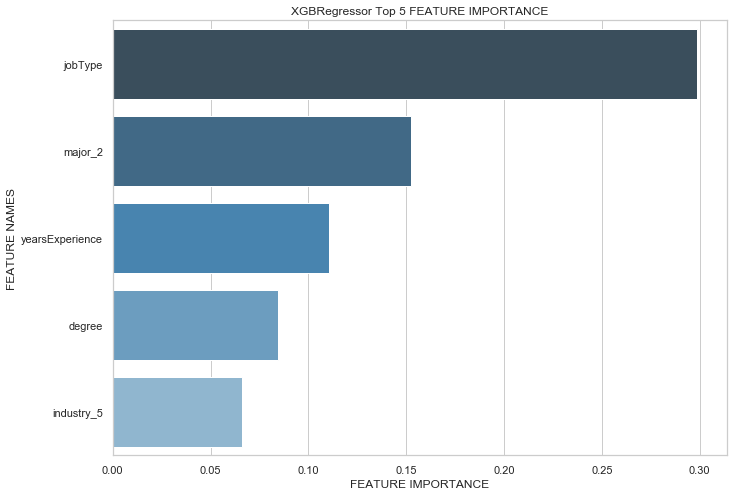

In [145]:
plot_feature_importance(imp,feature_names, 'XGBRegressor')

In [135]:
def save_results(model, mean_mse, predictions):
    with open('best_model.txt', 'w') as file:
        file.write(str(model))
    np.savetxt('predictions.csv', predictions, delimiter=',')

In [136]:
save_results(model, mean_mse, predictions)